# Chapter 4: LMS-Based Algorithms

## Imports 

In [127]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import SignError
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Problem 8

$$x = n(k) \rightarrow R = \sigma_{x}^2 I \rightarrow \lambda_i = \sigma_{x}^2$$

$\xi(k) = \xi_{min} = \sigma_n^2$ (Minimum measurement error)



$$H(z) = \frac{1}{1-0.9z^{-1}}$$

$$h(n) = 0.9h(n-1) + x(n)$$




In [153]:
output_filepath = './Outputs/Chap_4/Exercise_9/'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
R = sigma_x2*np.eye(N)
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = 1/np.trace(R)*(np.sqrt(np.pi*mse_estimate/2))
print ('mu_max: ', mu_max)

mu_max:  0.095931009868


### (b)

In [154]:
K = 4000             # number of iterations (signal length)
factor = 10
mu = mu_max/factor
def run_problem_8(K, mu):
    d = np.zeros([K]) # Desired signal        
    x = np.random.uniform(-1, 1, K)
    x = (x-x.mean())/np.sqrt(x.var()/sigma_x2) # Input signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Noise signal

    for k in np.arange(K):
        d[k] = .9*d[k-1]+x[k]+n[k] if k != 0 else x[k]+n[k]

    # Fitting algorithm
    model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    model.fit(d, x)  
    
    MSE_min = np.zeros([K])
    arr = 0.9**11*0.9**(np.arange(K, 0, -1))
    
    for k in np.arange(K):
        if (k<N):
            MSE_min[k] = n[k]**2
        else:
            MSE_min[k] = n[k]**2+(np.dot(arr[::-1][:k-N] ** 2,x[:k-N] ** 2))

    
    return model, n, x, MSE_min

model, n, x, MSE_min = run_problem_8(K, mu)
print (model)

SignError(step=0.009593100986803105, filter_order=11)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


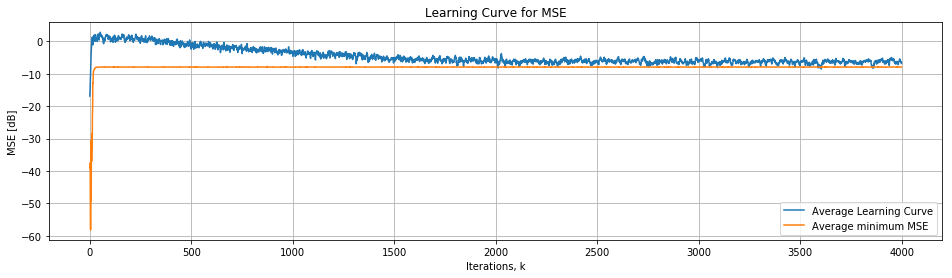

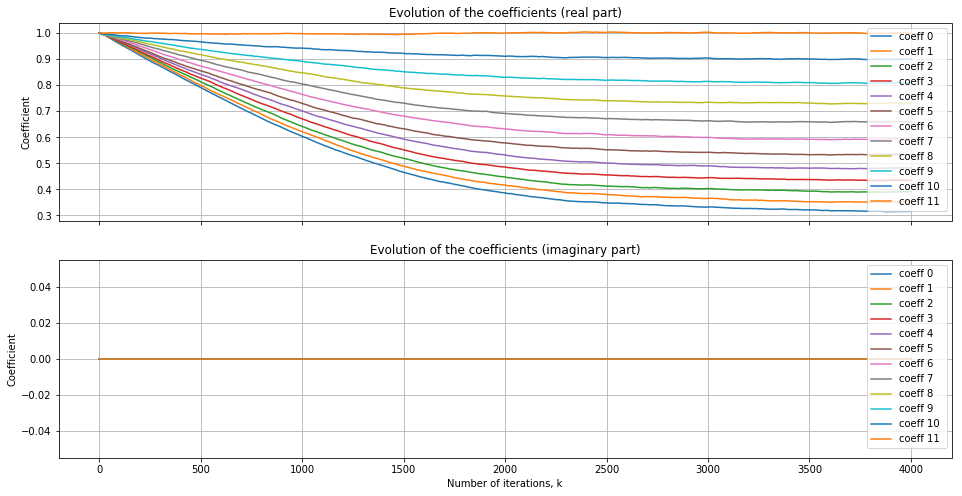

In [168]:
%time
n_ensembles = 100   # number of realizations within the ensemble
K = 4000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
frac = 100
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x, MSE_min = run_problem_8(K, mu)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    
    
    MSE_min[ensemble] = MSE_min[ensemble] + 0
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSE_min, W_av, None, output_filepath=None, algorithm='LMS_run'+str(n_ensembles) )

### (c)

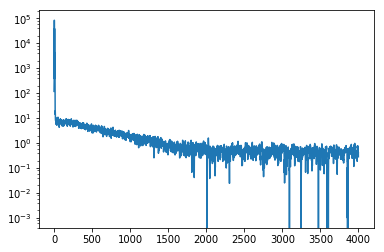

In [169]:
plt.plot((MSE_av-MSE_min)/MSE_min)
plt.yscale('log')

mu_max/100: M_theoretical = 0.015707963267948963


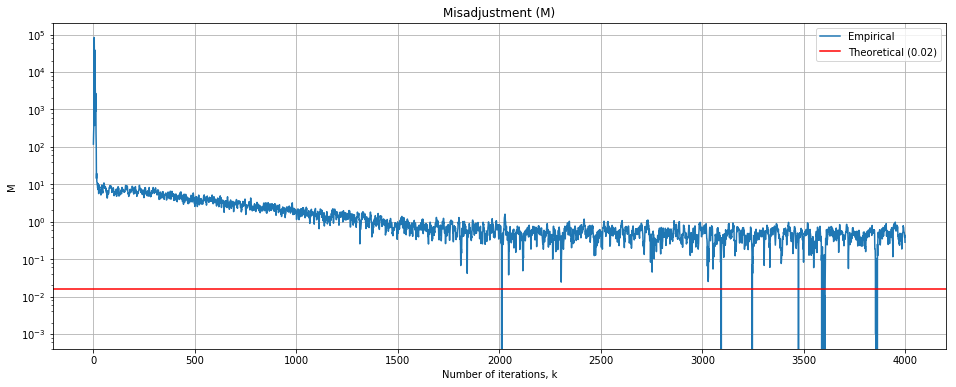

In [172]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot((MSE_av-MSE_min)/MSE_min, label='Empirical')
ax.axhline(m_theoretical, color='r', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

# if output_filepath is not None:        
#     fig.savefig(output_filepath + 'c_misadjustment_mu'+str(div)+'.jpg', bbox_inches = 'tight')